<a href="https://colab.research.google.com/github/Leandro-Braga/Estudo_de_Caso/blob/main/Novo-2_Day_ARIMA_ordem_p_d_q.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Séries logísticas

O conhecimento de logística oferece ao profissional a oportunidade de compreender a logística e a cadeia de suprimentos, indispensáveis ferramentas integradoras dos recursos e processos empresariais para a realização da estratégia corporativa.

O objetivo das empresas na fabricação de bens, na distribuição de insumos, no dimensionamento de transportes é verificar a capacidade em relação à quantidade produzida ou ofertada, utilizando completamente os seus recursos para obtenção máxima de lucratividade.

Surgiram os estudos sobre previsões de mercado ou de demanda, em que a estratégia era ofertar apenas o necessário para consumo e evitar o máximo todo tipo de desperdício. Em dias mais atuais, o mercado se tornou cada vez mais competitivo, não tendo espaço para subdimensionamento. A previsão de demanda é necessária e importante para o adequado uso dos recursos e das pessoas, fazendo com que as quantidades exatas para atender às atividades nos processos sejam inteligentemente programadas.

As séries temporais logísticas, principalmente as séries de demanda, podem apresentar algumas características que são comuns a outras séries temporais, como tendência, sazonalidade, pontos influentes, heterocedasticidade condicional e não linearidade. Então, podemos entender as séries logísticas como geradoras de processos estocásticos.

In [30]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns

Em seguida, carreguaremos o arquivo Excel, com a séries logísticas, e lembre-se de que o separador deve ser ponto e a data no formato americano.

In [31]:
df = pd.read_excel('sample_data/dados_day.xlsx' )
df.head()

,Day,Value
0,2021-01-01,5.64
1,2021-01-02,4.45
2,2021-01-03,3.08
3,2021-01-04,6.61
4,2021-01-05,5.08


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Day     100 non-null    datetime64[ns]
 1   Value   100 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.7 KB


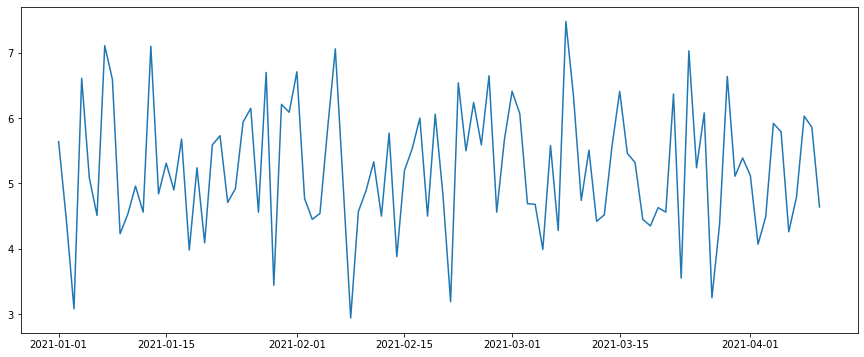

In [33]:
# plotar gráfico da Produção Industrial mensal PIM-PF
plt.plot(df.Day, df.Value);

Antes de fazer a decomposição da série, temos que transformar a data em índice:

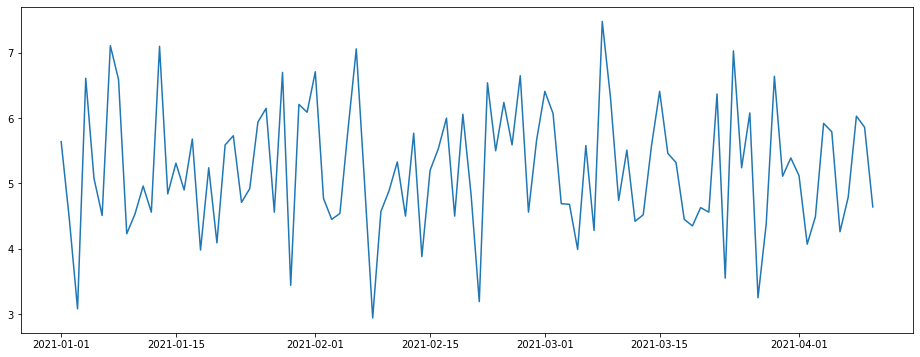

In [34]:
#Transformar da data em índice
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
df.Day = pd.to_datetime(df.Day)
df.set_index('Day', inplace=True)
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(111)
ax.plot(df)

In [28]:
# # Transformar da data em índice
# from matplotlib.pylab import rcParams
# rcParams['figure.figsize'] = 15, 6
# df.Day = pd.to_datetime(df.Day)
# df.set_index('Day', inplace=True)

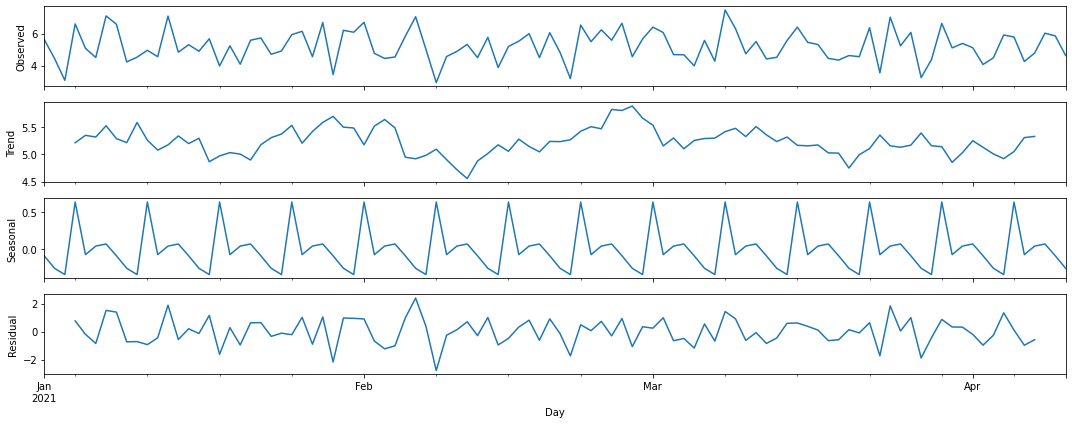

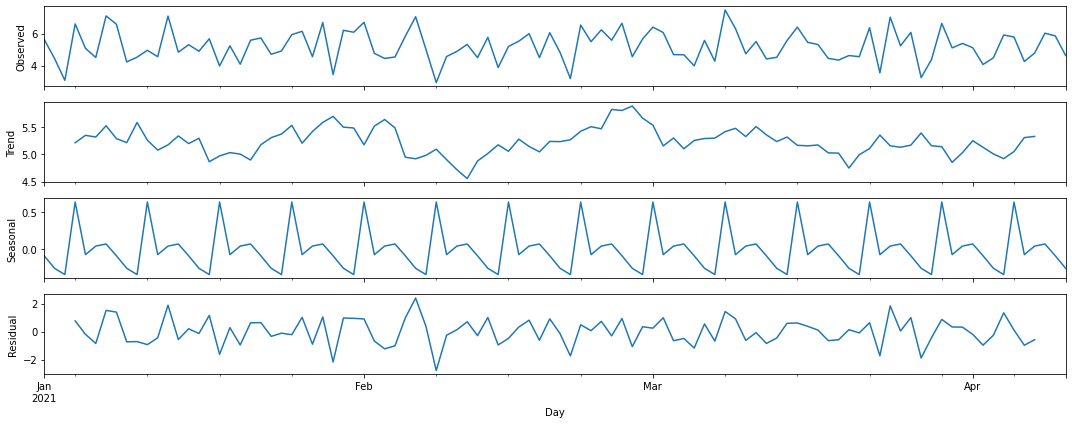

In [35]:
# salvar a decomposição no modelo aditivo
result = seasonal_decompose(df, model='additive')
result.plot()

Vamos aplicar a decomposição multiplicativa à série:

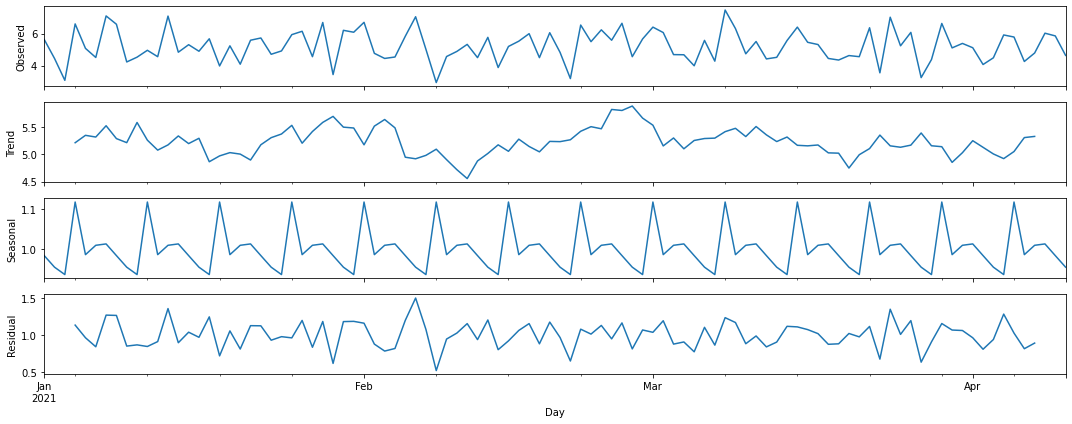

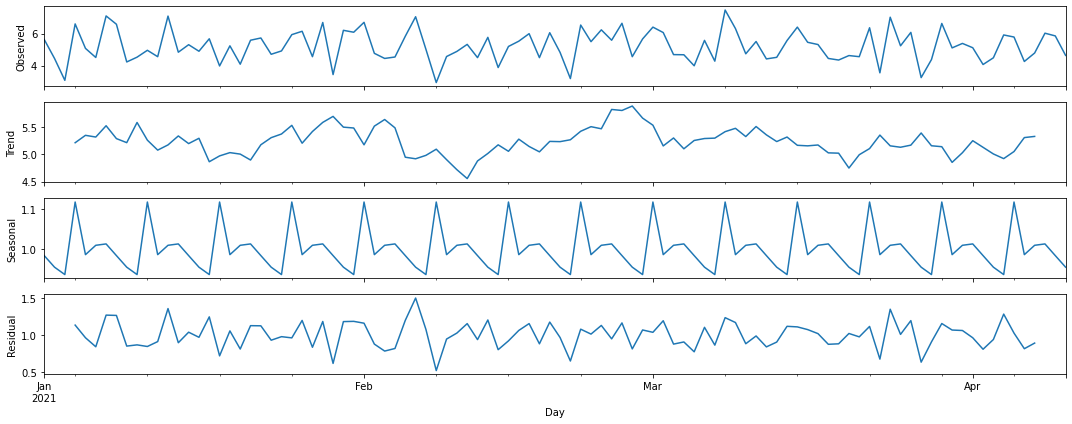

In [36]:
# decompõe a série de acordo com o modelo multiplicativo 
result = seasonal_decompose(df, model='multiplicative')
result.plot()

Observa-se um padrão muito similar entre os modelos de decomposição aditivo e multiplicativo, pois existe pouca ou nenhuma tendência na série. A diferença entre os modelos é maior quando a sazonalidade depende da tendência.

### Modelos de suavização para séries logísticas

Consiste em utilizar como previsão a média simples das observações mais recentes. Consideraremos a média de k valores consecutivos, podemos tomar a média do último ano, ou seja, os últimos 12 valores. O pacote Pandas tem funções específicas definidas para determinar médias móveis como:

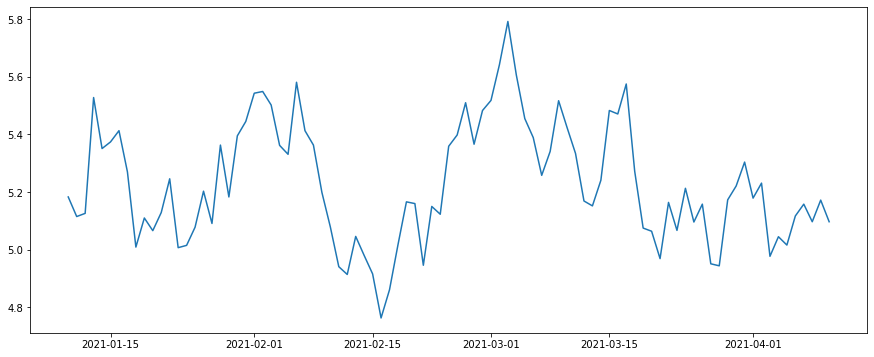

In [37]:
# Modelo de Médias Móveis com k=10
dados = df
mm = pd.DataFrame.rolling(dados,window=10,center=False).mean()
plt.plot(mm)

Outro exemplo:

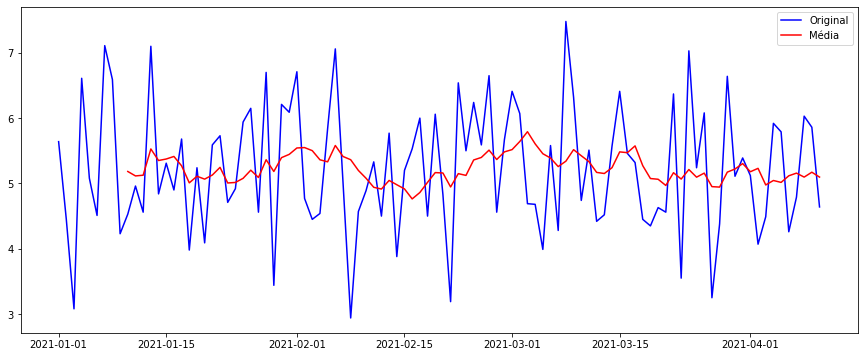

In [38]:
# Modelo de Médias Móveis comparado a série com k=10
mm = pd.DataFrame.rolling(dados,window=10,center=False).mean()
orig = plt.plot(dados, color='blue',label='Original')
mean = plt.plot(mm, color='red',label='Média')
plt.legend(loc='best')
plt.show()

Agora, vamos rodar o modelo de médias móveis para k=3, e o resultado obtido está ilustrado no gráfico a seguir:

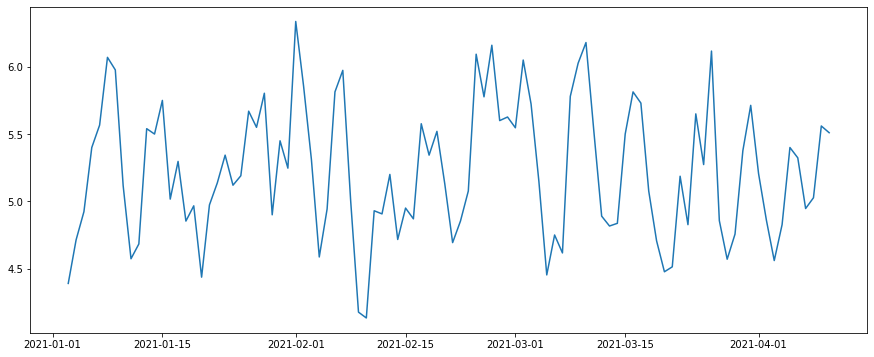

In [39]:
# Modelo de Médias Móveis com k=3
mm = pd.DataFrame.rolling(dados,window=3,center=False).mean()
plt.plot(mm)

Vamos executar o código com k=3.

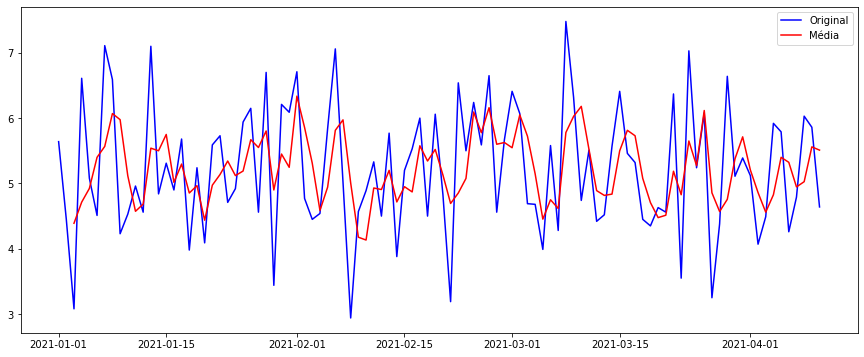

In [40]:
# Modelo de Médias Móveis comparado a série com k=3
mm = pd.DataFrame.rolling(dados,window=3,center=False).mean()
orig = plt.plot(dados, color='blue',label='Original')
mean = plt.plot(mm, color='red',label='Média')
plt.legend(loc='best')
plt.show()

Os dois modelos suavizam a série logística. No entanto, comparando-se o modelo médias móveis com k=10 e com k=3 observa-se que o modelo com k=10 retira os picos sazonais, o que não ocorre com k=3. Se quisermos realizar previsões para a série sem sazonalidade, devemos escolher o modelo de médias móveis com k=10.

Para contornar esse problema, surge o método do amortecimento exponencial. Para realizar previsões K passos à frente utilizando o modelo de médias móveis, utilizamos o seguinte código para previsão 1 passo à frente e 10 passos à frente:

In [41]:
def moving_average(series, n):
    '''Calcula a média das últimas n observações'''
    return np.average(series[-n:])

Calculando a previsão para 12 passos à frente:

In [42]:
# Previsão 10 passos à frente
moving_average(dados, 10)

5.0969999999999995

Agora, calculando a previsão para 1 passo à frente:

In [43]:
# Previsão 1 passos à frente
moving_average(dados, 1)

4.64

### Método amortecimento exponencial para séries logísticas

Vamos executar o código para Amortecimento Exponencial (sem constante de amortecimento) a seguir:

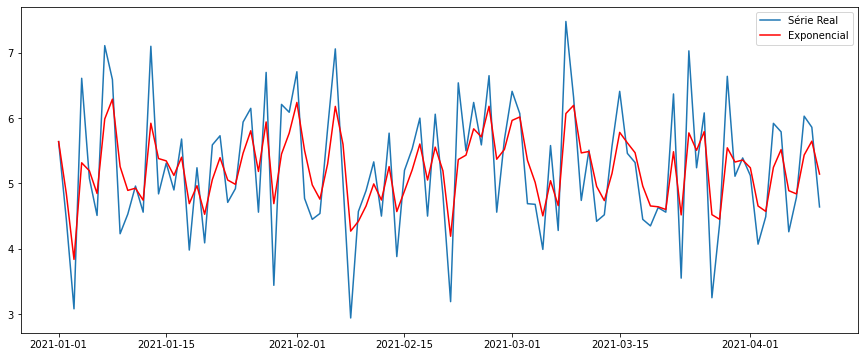

In [44]:
# Amortecimento Exponencial alfa = 0,5
rolling = dados.ewm(alpha=0.5)
rolling_mean = rolling.mean()
plt.plot(dados, label='Série Real')
plt.plot(rolling_mean, color='red', label='Exponencial')
plt.legend(loc='best')
plt.show()

Agora, vamos executar o código Python para Amortecimento Exponencial (com constante de amortecimento = 0,3).

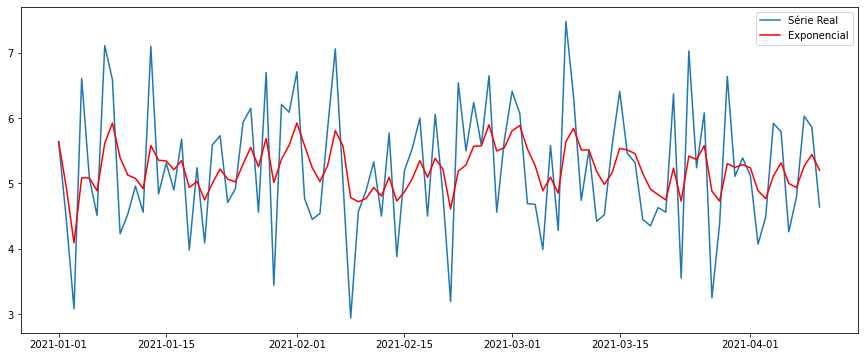

In [45]:
# Amortecimento Exponencial alfa = 0,3
rolling = dados.ewm(alpha=0.3)
rolling_mean = rolling.mean()
plt.plot(dados, label='Série Real')
plt.plot(rolling_mean, color='red', label='Exponencial')
plt.legend(loc='best')
plt.show()

Gráfico comparando mais de um valor da constante de amortecimento:

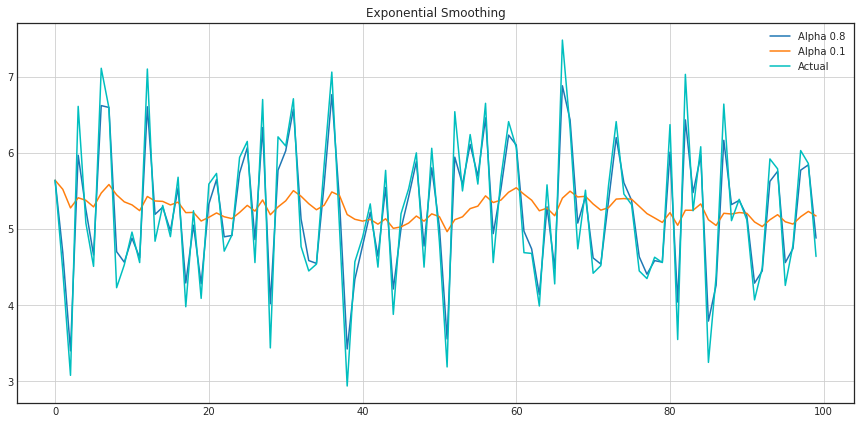

In [46]:
#Função para comparação com duas constantes de amortecimento:
def exponential_smoothing(series, alpha):
    '''
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    '''
    result = [series[0]] # o primeiro valor é o mesmo que a série
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
    
def plotExponentialSmoothing(series, alphas):
    '''
        Plota suavização exponencial com diferentes alfas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    '''
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label='Alpha {}'.format(alpha))
        plt.plot(series.values, 'c', label = 'Actual')
        plt.legend(loc='best')
        plt.axis('tight')
        plt.title('Exponential Smoothing')
        plt.grid(True);
plotExponentialSmoothing(dados.Value, [0.8, 0.1])

Gráfico: Comparação com duas constantes de amortecimento.

### Método de Holt Winters para séries logísticas

O método de Holt-Winters compreende a equação de previsão e três equações de suavização.

Primeiramente, rodaremos o modelo de Holt-Winters somente com o nível e o alfa de 0,1:

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


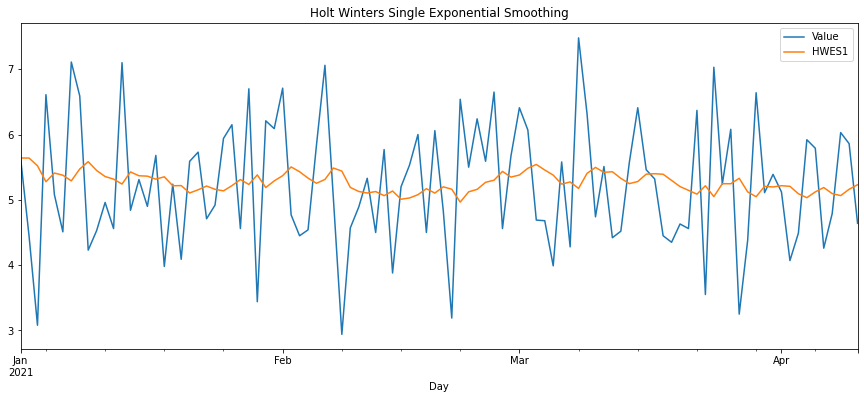

In [47]:
# holt winters (somente com o nível)
# single exponential smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
# double and triple exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
# Set the value of Alpha and define m (Time Period)
alpha = 0.1
df['HWES1'] = SimpleExpSmoothing(df['Value']).fit(smoothing_level=alpha,optimized=False,use_brute=True).fittedvalues
df[['Value','HWES1']].plot(title='Holt Winters Single Exponential Smoothing');

Em seguida, é o modelo de Holt-Winters somente com a tendência, para um modelo aditivo e multiplicativo:

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


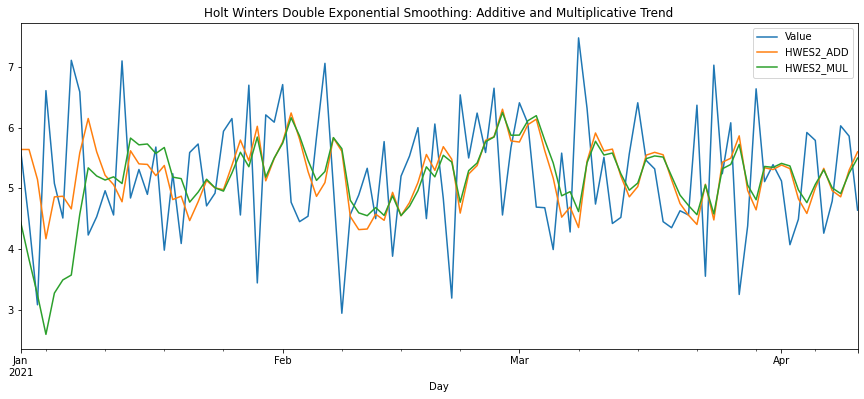

In [48]:
# holt winters (somente com o nível e a tendência aditiva e multiplicativa)
df['HWES2_ADD'] = ExponentialSmoothing(df['Value'],trend='add').fit().fittedvalues
df['HWES2_MUL'] = ExponentialSmoothing(df['Value'],trend='mul').fit().fittedvalues
df[['Value','HWES2_ADD','HWES2_MUL']].plot(title='Holt Winters Double Exponential Smoothing: Additive and Multiplicative Trend');

Gráfico: Holt-Winters somente com a tendência para um modelo aditivo e multiplicativo.

Por último, temos o modelo de Holt-Winters com nível, com a tendência e sazonalidade, tanto para um modelo aditivo quanto multiplicativo:

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


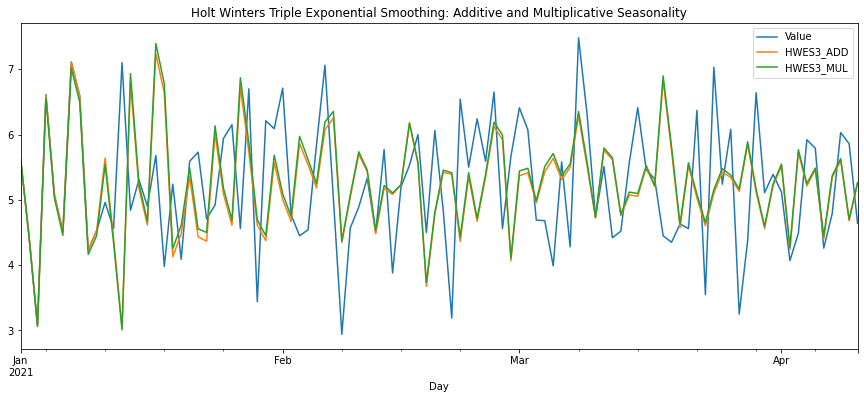

In [49]:
# holt winters (nível, tendência e sazonalidade, aditiva e multiplicativa)
df['HWES3_ADD'] = ExponentialSmoothing(df['Value'],trend='add',seasonal='add',seasonal_periods=10).fit().fittedvalues
df['HWES3_MUL'] = ExponentialSmoothing(df['Value'],trend='mul',seasonal='mul',seasonal_periods=10).fit().fittedvalues
df[['Value','HWES3_ADD','HWES3_MUL']].plot(title='Holt Winters Triple Exponential Smoothing: Additive and Multiplicative Seasonality');

Gráfico: Holt-Winters com nível, tendência e sazonalidade para modelo aditivo e modelo multiplicativo.

Vamos fazer a previsão, utilizando o modelo de Holt-Winters. Começaremos dividindo o conjunto de dados em treino e teste. Pegamos 99 dados como conjunto de treino e os últimos 10 últimos pontos de dados como conjunto de teste:

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


Text(0.5, 1.0, 'Train, Test and Predicted Test using Holt Winters')

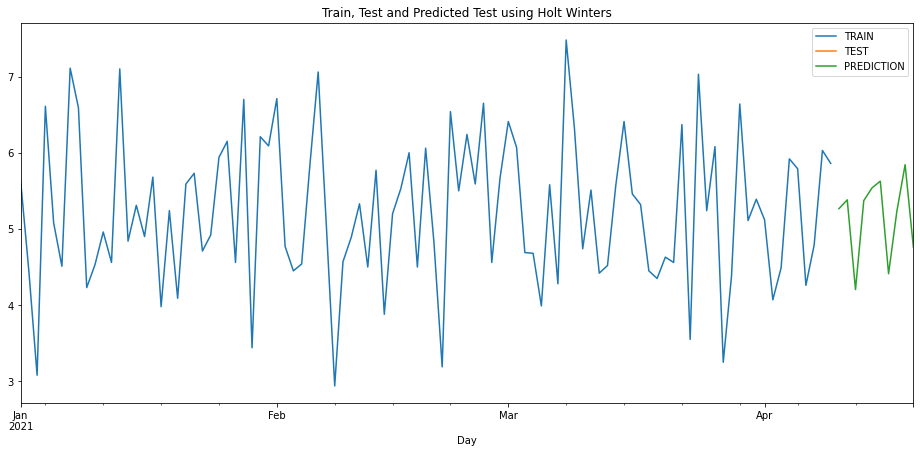

In [50]:
#Previsão 10 passos a frente com modelo de Holt-Winters
train_df = df[:99]
test_df = df[99:]
fitted_model = ExponentialSmoothing(train_df['Value'],trend='mul',seasonal='mul',seasonal_periods=10).fit()
test_predictions = fitted_model.forecast(10)
train_df['Value'].plot(legend=True,label='TRAIN')
test_df['Value'].plot(legend=True,label='TEST',figsize=(16,7))
test_predictions.plot(legend=True,label='PREDICTION')
plt.title('Train, Test and Predicted Test using Holt Winters')

Gráfico: Previsão 10 passos à frente com modelo de Holt-Winters.

Podemos observar que as previsões feitas com o modelo de Holt-Winters se ajustam bem, pois, comparando o período de teste com os valores previstos, vemos que existe o mesmo comportamento da série.

### Modelagem ARIMA para séries logísticas

Utilizaremos a metodologia proposta por Box & Jenkins para a análise de uma série temporal logística, começando pela identificação do modelo. A identificação não pretende definir o modelo final para representar a série. Se assim fosse, não haveria necessidade das outras etapas de modelagem. Como já vimos, o objetivo é apenas definir os valores de p, d e q que, inicialmente, sejam adequados para modelar a série porque, segundo os autores do método, esse diagnóstico costuma conduzir a um modelo subespecificado, menor do que o modelo verdadeiro para a série.

Fazemos o gráfico da função de autocorrelação (FAC) e função de autocorrelação parcial (FAC) para confirmar se a série é estacionária.

In [ ]:
df = pd.read_excel('sample_data/dados_day.xlsx')
df.head()

,Day,Value
0,2021-01-01,5.64
1,2021-01-02,4.45
2,2021-01-03,3.08
3,2021-01-04,6.61
4,2021-01-05,5.08


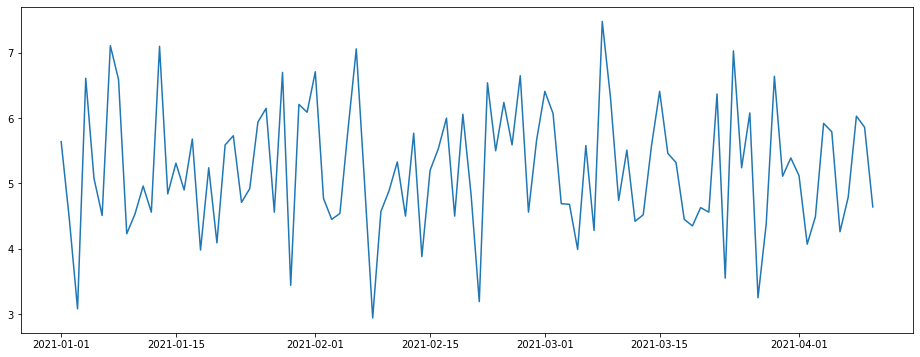

In [ ]:
#Transformar da data em índice
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
df.Day = pd.to_datetime(df.Day)
df.set_index('Day', inplace=True)
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(111)
ax.plot(df)

In [51]:
# data como índice
df.head()

,Value,HWES1,HWES2_ADD,HWES2_MUL,HWES3_ADD,HWES3_MUL
Day,,,,,,
2021-01-01,5.64,5.64000,5.640000,4.450000,5.64,5.627137
2021-01-02,4.45,5.64000,5.640000,3.827763,4.45,4.430286
2021-01-03,3.08,5.52100,5.145540,3.243762,3.08,3.060136
2021-01-04,6.61,5.27690,4.168612,2.591978,6.61,6.554870
2021-01-05,5.08,5.41021,4.858387,3.272598,5.08,5.028668


In [53]:
df_novo = df.drop(columns=['HWES1', 'HWES2_ADD','HWES2_MUL','HWES3_ADD','HWES3_MUL'])
df_novo.head()

,Value
Day,
2021-01-01,5.64
2021-01-02,4.45
2021-01-03,3.08
2021-01-04,6.61
2021-01-05,5.08


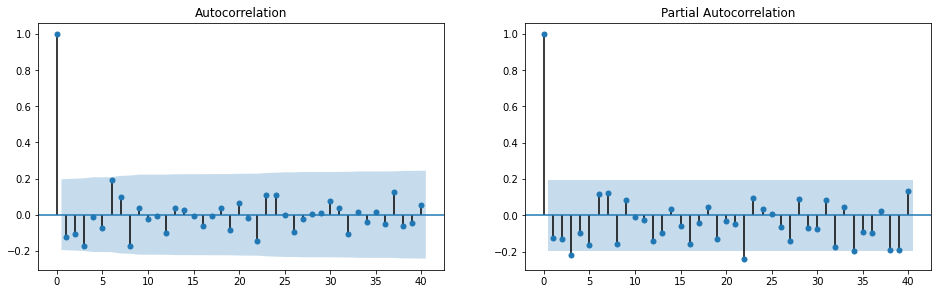

In [92]:
# Função de autocorrelação (FAC) e função de autocorrelação parcial (FAC)

def acf_pacf(x):
  
    fig = plt.figure(figsize=(16,10))
    ax1 = fig.add_subplot(221)
    fig = sm.graphics.tsa.plot_acf(x, lags=40, ax=ax1)
    ax2 = fig.add_subplot(222)
    fig = sm.graphics.tsa.plot_pacf(x, lags=40, ax=ax2)

acf_pacf(df_novo)

Observa-se que a FAC decai lentamente. Isso é um indício de que a série não é estacionária; podemos transformar a série para fazer com que ela fique estacionária. Uma transformação seria fazer o log retorno do valor da PIM:

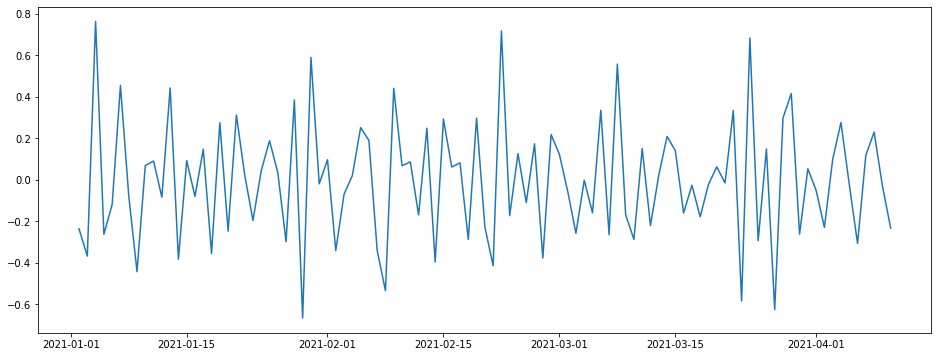

In [93]:
#Transformação para tornar a série estacionária
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(111)
ax.plot(np.log(df_novo).diff().dropna());

Gráfico: Série estacionária.

A série transformada, após uma diferença, ou seja, foi identificado que d=1 e aplicada à função logarítmica ficou estacionária; como a condição para estimar o modelo ARMA é que a série seja estacionária, podemos seguir com a análise:

Dessa maneira, o procedimento sugerido por Box & Jenkins para a identificação das ordens p e q de um modelo de séries temporais é, a partir da série que se quer analisar, estimar a FAC obtendo o gráfico da FAC e da FACP amostral.

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


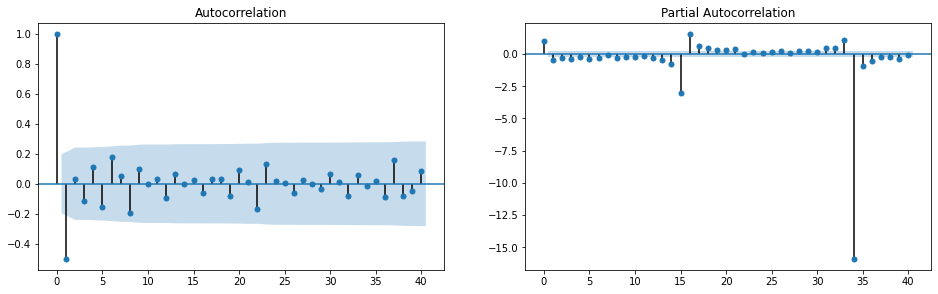

In [94]:
# FAC e FACP para série estacionária
acf_pacf(np.log(df_novo).diff().dropna())

Gráfico: FAC e FACP para série estacionária.

Observamos que, mesmo após a diferença, a série apresenta os pontos fora do intervalo de confiança; esses pontos estão ocorrendo a cada lag múltiplo de 10, o que caracteriza que necessita de diferença sazonais.

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


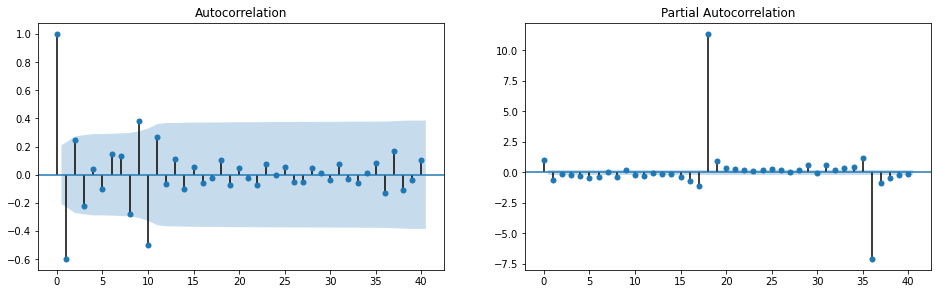

In [95]:
# FAC e FACP para série estacionária
acf_pacf(np.log(df_novo).diff().diff(10).dropna())

Gráfico: FAC e FACP para série estacionária.

A FAC está truncada em q=2, o que poderia sugerir um modelo MA(2) e a FACP apresenta uma mistura dos comportamentos. Para a séria da PIM, o modelo sugerido seria um SARIMA(p,d,q)(P,D,Q), por se tratar de um modelo sazonal, mas estimaremos um modelo ARIMA(p,d,q) para ilustração.

Faremos mais uma transformação, elevando ao quadrado o valor da variação da PIM:

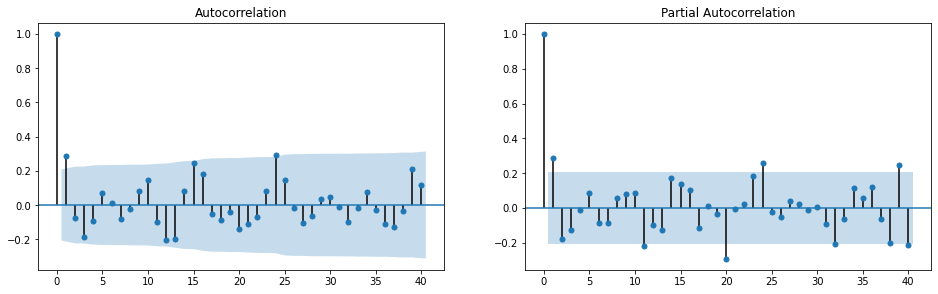

In [96]:
acf_pacf(np.log(df_novo).diff().diff(10).dropna() ** 2)

O valor da série da PIM transformada apresenta tanto características de AR(1) como de MA(1), caracterizando um processo ARMA(1,1), pois a FAC de um MA(1) é truncada em q=1 e a FACP de um AR(1) é truncada em p=1. Essa é a fase de identificação.

Na fase de estimação, estimamos os parâmetros do modelo, sendo assim, estimaremos o modelo ARIMA(p,d,q), em que p=1, q=1 e d=1, sendo um ARIMA(1,1,1):

In [97]:
# Ajuste do modelo ARIMA(1,1,1)
model = sm.tsa.ARIMA(1000 * (np.log(df_novo).diff().dropna() ** 2), order=(1,1,1)).fit()
print(model.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                   98
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -606.979
Method:                       css-mle   S.D. of innovations            116.005
Date:                Mon, 24 Jan 2022   AIC                           1221.957
Time:                        04:09:51   BIC                           1232.297
Sample:                    01-03-2021   HQIC                          1226.139
                         - 04-10-2021                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.3622      0.525     -0.690      0.492      -1.391       0.666
ar.L1.D.Value     0.2296      0.099      2.321      0.022       0.036       0.423
ma.L1.D.Value    -1.0000      0.027    -

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Ajuste do modelo ARIMA(1,1,1)

Porém, como mencionado antes, esse não necessariamente é o modelo final, uma vez que o procedimento de identificação tende a subidentificar o modelo, isto é, a conduzir a valores de p e/ou q que são menores que os reais. Uma vez identificado e estimado um modelo, devemos diagnosticar o modelo e verificar se os resíduos apresentam as propriedades esperadas para eles. Ou seja, se eles se comportam como um ruído branco.

**O passo mais importante é detectar a possibilidade de autocorrelação. Se os resíduos apresentarem algum padrão de dependência temporal, o modelo é invalidado.**

Para começar a fase de diagnóstico, vamos fazer o gráfico dos resíduos:

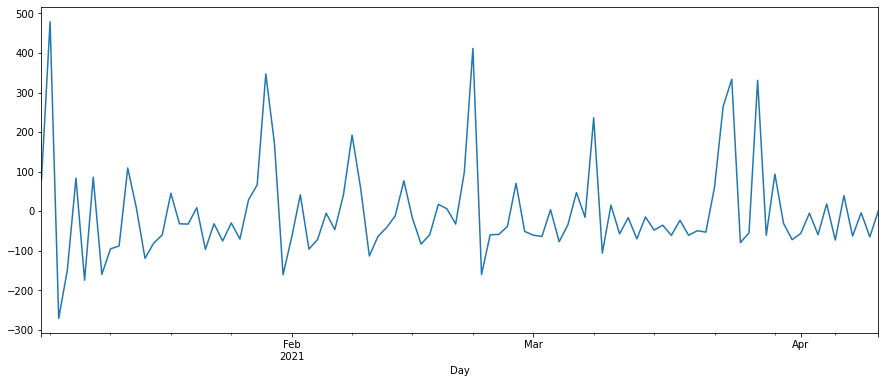

In [98]:
# Gráfico dos resíduos
model.resid.plot()

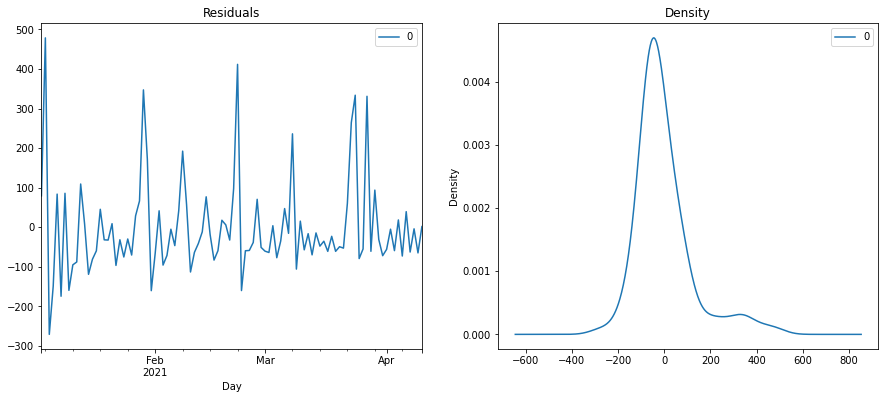

In [99]:
residuals = pd.DataFrame(model.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

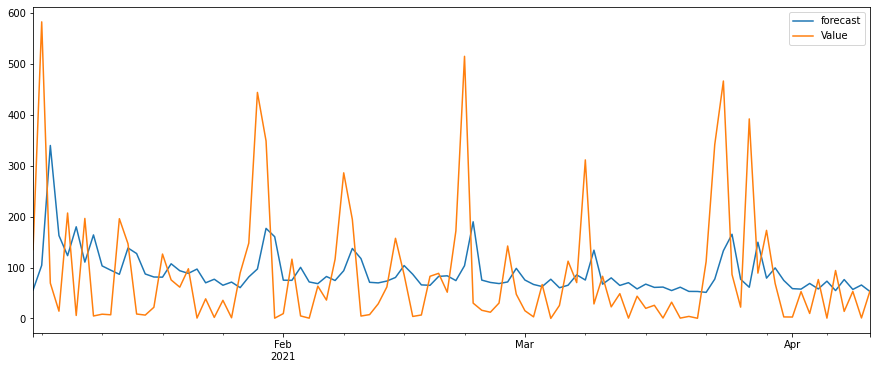

In [100]:
model.plot_predict(dynamic=False)
plt.show()

Gráfico: Resíduos.

Os resíduos não são estacionários, não possuem a média zero, sendo necessário retornar à fase de identificação para estimar outro modelo, provavelmente um modelo SARIMA.

**O modelo ARIMA pode ser ampliado para considerar a sazonalidade da série temporal. O modelo resultante é denominado SARIMA (= Seasonal ARIMA).**

Modelos SARIMA não permitem isolar a componente sazonal, portanto, não possibilitam ajustar sazonalmente (ou dessazonalizar) a série. Entretanto, constituem-se um poderoso e flexível instrumento para prever séries sazonais.

In [ ]:
# Modelo SARIMA
mod = sm.tsa.statespace.SARIMAX(df,
                order=(2, 2, 2),
                seasonal_order=(2, 2, 2, 10),
                enforce_stationarity=False,
                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -4.4026   2.36e+06  -1.87e-06      1.000   -4.62e+06    4.62e+06
ar.L2         -2.9138   1.59e+06  -1.83e-06      1.000   -3.12e+06    3.12e+06
ma.L1         -1.3810     75.677     -0.018      0.985    -149.705     146.943
ma.L2         -3.7194    102.547     -0.036      0.971    -204.708     197.270
ar.S.L10      -0.7219   1.61e+05  -4.49e-06      1.000   -3.15e+05    3.15e+05
ar.S.L20      -0.6455   7508.493   -8.6e-05      1.000   -1.47e+04    1.47e+04
ma.S.L10   -3.259e+13    3.9e+05  -8.36e+07      0.000   -3.26e+13   -3.26e+13
ma.S.L20    2.218e+13   2.29e-06   9.67e+18      0.000    2.22e+13    2.22e+13
sigma2         1.8233    100.413      0.018      0.986    -194.982     198.629


Como alguns parâmetros não são significativos, rodamos um novo modelo, SARIMA(2,1,1)(1,12), que se ajustou melhor aos dados da PIM:

In [ ]:
# Modelo SARIMA (2,1,1)
mod = sm.tsa.statespace.SARIMAX(df,
                order=(2, 1, 1),
                seasonal_order=(2, 1, 1, 10),
                enforce_stationarity=False,
                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0200      0.126     -0.159      0.874      -0.267       0.227
ar.L2         -0.0394      0.146     -0.270      0.787      -0.325       0.246
ma.L1         -1.0000    555.655     -0.002      0.999   -1090.064    1088.064
ar.S.L10      -0.5522      0.214     -2.580      0.010      -0.972      -0.133
ar.S.L20      -0.2502      0.158     -1.588      0.112      -0.559       0.059
ma.S.L10      -0.2710      0.270     -1.003      0.316      -0.801       0.259
sigma2         1.0235    568.741      0.002      0.999   -1113.688    1115.735


Observamos que a série logística da PIM pode estimar um modelo SARIMA, ou seja, ARIMA com sazonalidade.